In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Required Packages

In [3]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.1 MB/s 

# Load Model and Setup Grad-CAM

In [4]:
import cv2
import numpy as np
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from torchvision import models, transforms
from PIL import Image

# Load the trained model
def load_model(checkpoint_path):
    model = models.resnet18(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 4)
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
    model.eval()
    return model


model = load_model("/content/drive/MyDrive/Brain/brain_tumor_resnet18.pth")

# Define target layer
target_layers = [model.layer4[-1].conv2]  # Last convolutional layer

# Create Grad-CAM object
cam = GradCAM(
    model=model,
    target_layers=target_layers,
)

In [5]:
def preprocess_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_preprocess(image_path):
    # Load image
    image = Image.open(image_path).convert('RGB')

    # Preprocess for model input
    transform = preprocess_transform()
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Preprocess for visualization (normalize to 0-1)
    rgb_img = np.array(image.resize((224, 224))) / 255.0

    return input_tensor, rgb_img

In [6]:
import matplotlib.pyplot as plt

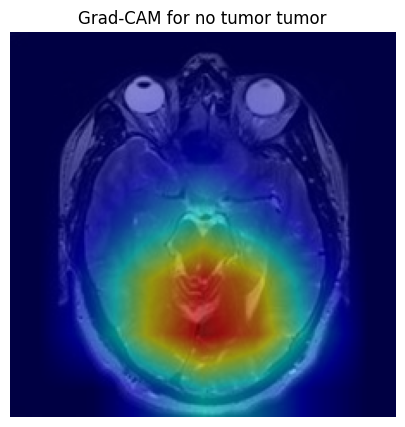

Predicted class: no tumor


In [7]:
def generate_gradcam(image_path, class_idx=None):
    # Preprocess image
    input_tensor, rgb_img = load_and_preprocess(image_path)

    # If no specific class is provided, use model's prediction
    if class_idx is None:
        with torch.no_grad():
            output = model(input_tensor)
            class_idx = torch.argmax(output).item()

    # Generate Grad-CAM
    grayscale_cam = cam(
        input_tensor=input_tensor,
        targets=None,  # We'll specify class_idx directly
        aug_smooth=True,  # Reduce noise
        eigen_smooth=True   # Smooth CAM
    )

    # Get the CAM for the target class
    grayscale_cam = grayscale_cam[0, :]

    # Overlay CAM on image
    visualization = show_cam_on_image(
        rgb_img,
        grayscale_cam,
        use_rgb=True
    )

    return visualization, class_idx

# Class names mapping
class_names = {0: 'glioma', 1: 'meningioma', 2: 'no tumor', 3: 'pituitary'}

# Example usage
image_path = "/content/drive/MyDrive/Brain/Testing/notumor/Te-no_0028.jpg"
cam_image, class_idx = generate_gradcam(image_path)

# Display results
plt.figure(figsize=(10, 5))
plt.imshow(cam_image)
plt.title(f"Grad-CAM for {class_names[class_idx]} tumor")
plt.axis('off')
plt.show()

print(f"Predicted class: {class_names[class_idx]}")

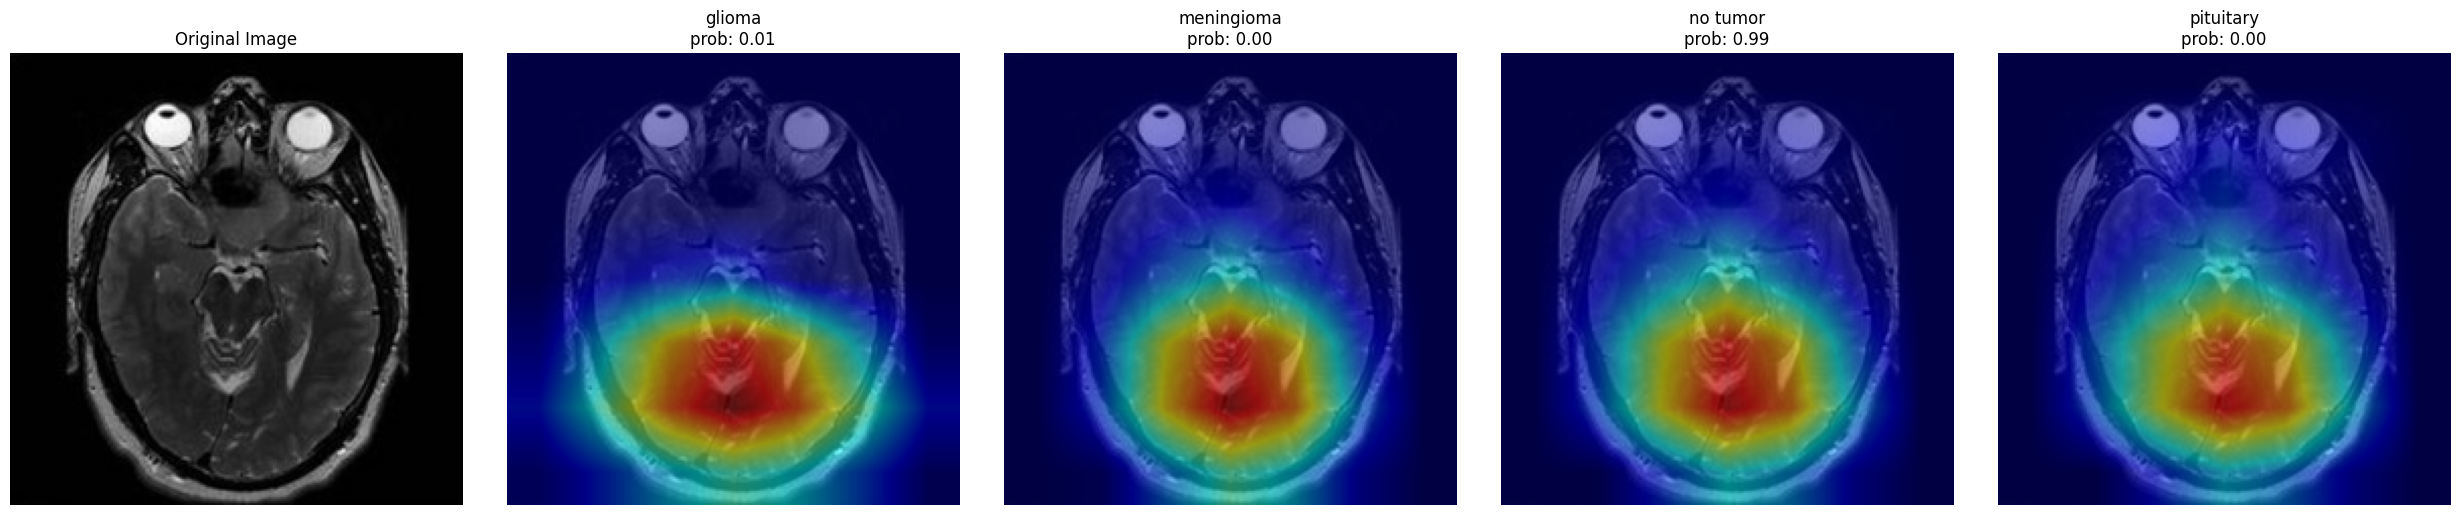

In [8]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def multi_target_gradcam(image_path):
    # Preprocess image
    input_tensor, rgb_img = load_and_preprocess(image_path)

    # Get model predictions
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]

    # Create visualization grid
    fig, axs = plt.subplots(1, 5, figsize=(25, 5))

    # Original image
    axs[0].imshow(rgb_img)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    # Generate CAM for each class
    for i, class_name in class_names.items():
        # Generate CAM for this class
        grayscale_cam = cam(
            input_tensor=input_tensor,
            targets=[ClassifierOutputTarget(i)],
            aug_smooth=True,
            eigen_smooth=True
        )[0, :]

        # Create visualization
        visualization = show_cam_on_image(
            rgb_img,
            grayscale_cam,
            use_rgb=True
        )

        # Add to plot
        axs[i+1].imshow(visualization)
        axs[i+1].set_title(f"{class_name}\nprob: {probabilities[i]:.2f}")
        axs[i+1].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
multi_target_gradcam(image_path)

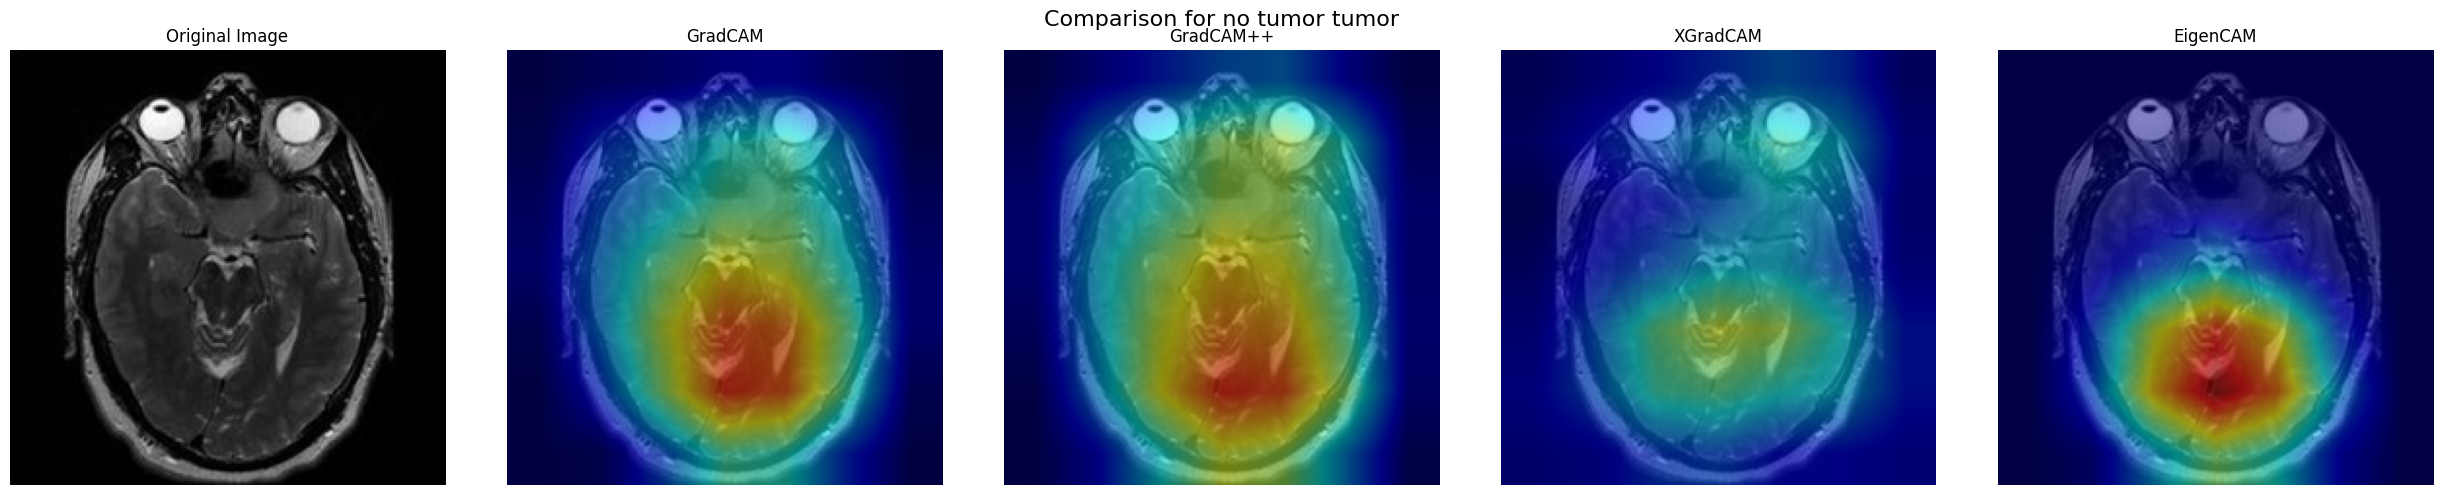

In [9]:
from pytorch_grad_cam import (
    GradCAM,
    GradCAMPlusPlus,
    XGradCAM,
    EigenCAM
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Create different CAM methods
methods = {
    "GradCAM": GradCAM,
    "GradCAM++": GradCAMPlusPlus,
    "XGradCAM": XGradCAM,
    "EigenCAM": EigenCAM
}

def compare_methods(image_path):
    # Preprocess image
    input_tensor, rgb_img = load_and_preprocess(image_path)

    # Get predicted class
    with torch.no_grad():
        output = model(input_tensor)
        class_idx = torch.argmax(output).item()

    # Create visualization grid
    fig, axs = plt.subplots(1, len(methods)+1, figsize=(25, 5))

    # Original image
    axs[0].imshow(rgb_img)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    # Generate CAM with each method
    for i, (name, method_class) in enumerate(methods.items()):
        # Create CAM object
        cam = method_class(
            model=model,
            target_layers=target_layers,
        )

        # Generate CAM
        grayscale_cam = cam(
            input_tensor=input_tensor,
            targets=[ClassifierOutputTarget(class_idx)],
            aug_smooth=True
        )[0, :]

        # Create visualization
        visualization = show_cam_on_image(
            rgb_img,
            grayscale_cam,
            use_rgb=True
        )

        # Add to plot
        axs[i+1].imshow(visualization)
        axs[i+1].set_title(f"{name}")
        axs[i+1].axis('off')

    plt.suptitle(f"Comparison for {class_names[class_idx]} tumor", fontsize=16)
    plt.tight_layout()
    plt.show()

# Usage
compare_methods(image_path)